# **Download Data**

In [1]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  31.1M      0  0:00:24  0:00:24 --:--:-- 32.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  11.7M      0  0:00:01  0:00:01 --:--:-- 11.7M


In [2]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

# **Prepare paths of input images and target segmentation masks**

In [91]:
import os

input_path = "./images/"
target_path = "./annotations/trimaps/"
IMGSIZE = (160, 160)
NUM_CLASSES = 4
batch_size = 32

In [126]:
input_img_paths = sorted([os.path.join(input_path, fname) for fname in os.listdir(input_path) if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(target_path, fname) for fname in os.listdir(target_path) if fname.endswith(".png") and not fname.startswith(".")])

In [127]:
print("Number of samples:", len(input_img_paths))
for i, j in zip(input_img_paths[:10], target_img_paths[:10]):
  print(i,"|", j)

Number of samples: 7390
./images/Abyssinian_1.jpg | ./annotations/trimaps/Abyssinian_1.png
./images/Abyssinian_10.jpg | ./annotations/trimaps/Abyssinian_10.png
./images/Abyssinian_100.jpg | ./annotations/trimaps/Abyssinian_100.png
./images/Abyssinian_101.jpg | ./annotations/trimaps/Abyssinian_101.png
./images/Abyssinian_102.jpg | ./annotations/trimaps/Abyssinian_102.png
./images/Abyssinian_103.jpg | ./annotations/trimaps/Abyssinian_103.png
./images/Abyssinian_104.jpg | ./annotations/trimaps/Abyssinian_104.png
./images/Abyssinian_105.jpg | ./annotations/trimaps/Abyssinian_105.png
./images/Abyssinian_106.jpg | ./annotations/trimaps/Abyssinian_106.png
./images/Abyssinian_107.jpg | ./annotations/trimaps/Abyssinian_107.png


# **What does one input image and corresponding segmentation mask look like?**

In [128]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

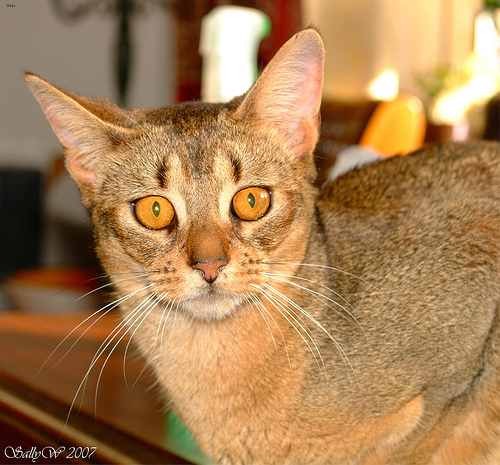

In [129]:
display(Image(filename=input_img_paths[4]))

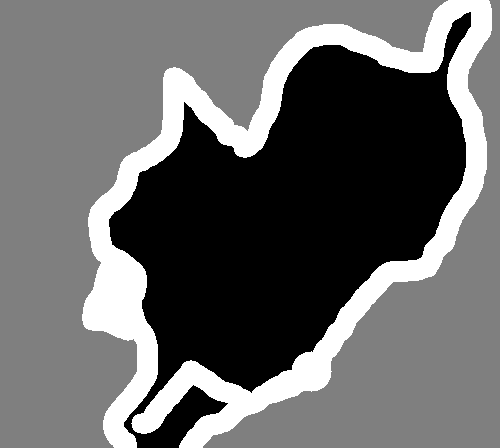

In [130]:
# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

# **Prepare `sequence` class to load & Vectorize batch of data**

In [131]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [132]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

# **Perpare U-Net Xception-style model**

In [133]:
from tensorflow.keras import layers

In [135]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [136]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [137]:
# Build model
model = get_model(img_size = IMGSIZE, num_classes = NUM_CLASSES)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# **U-net Architecture**

![](https://pic4.zhimg.com/v2-466a3bd53c8fc6f2cb338167947e4c0e_720w.jpg?source=172ae18b)


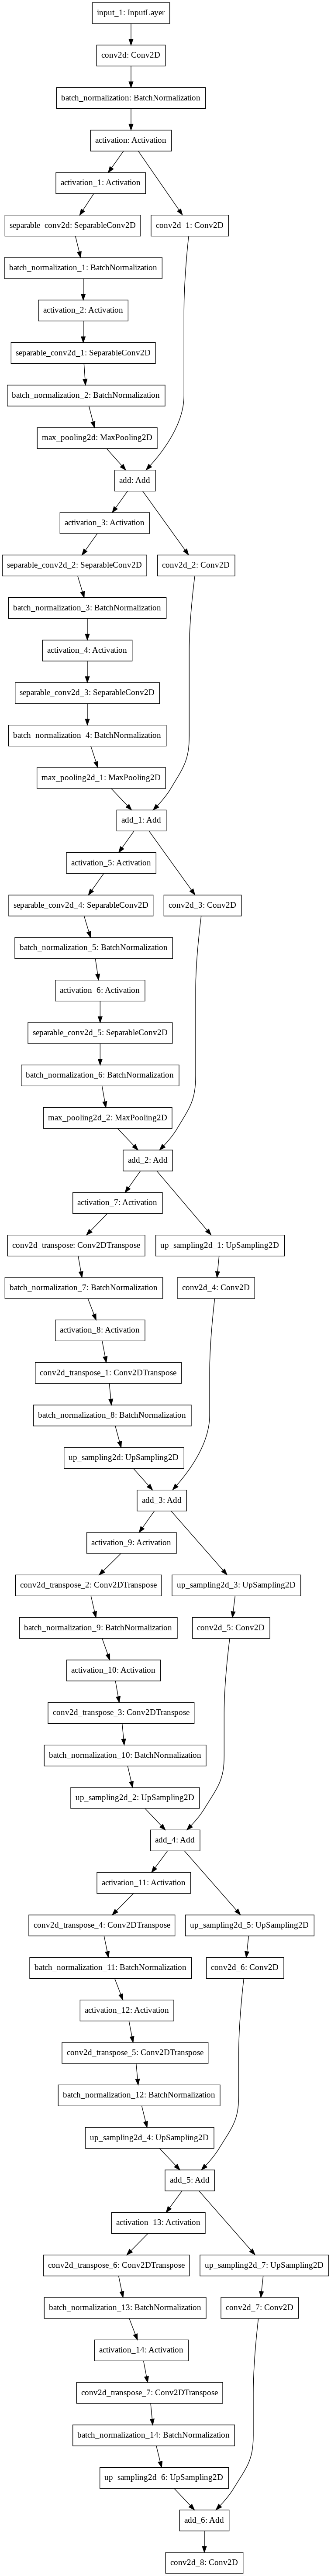

In [138]:
# model design
from tensorflow.keras.utils import plot_model
plot_model(model)

# **Set Aside a validation split**

In [142]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

# Train and validation Split
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size = IMGSIZE, input_img_paths= train_input_img_paths, target_img_paths = train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size = IMGSIZE, input_img_paths = val_input_img_paths, target_img_paths =val_target_img_paths)

In [ ]:
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 52s 259ms/step - loss: 1.0362 - val_loss: 4.6805
Epoch 2/15
199/199 [==============================] - 51s 255ms/step - loss: 0.4989 - val_loss: 2.3591
Epoch 3/15
199/199 [==============================] - 51s 256ms/step - loss: 0.4387 - val_loss: 0.4818
Epoch 4/15
199/199 [==============================] - 51s 256ms/step - loss: 0.3868 - val_loss: 0.4027
Epoch 5/15
199/199 [==============================] - 51s 254ms/step - loss: 0.3620 - val_loss: 0.3625
Epoch 6/15
199/199 [==============================] - 51s 254ms/step - loss: 0.3243 - val_loss: 0.3936
Epoch 7/15
199/199 [==============================] - 51s 255ms/step - loss: 0.2974 - val_loss: 0.3548
Epoch 8/15
199/199 [==============================] - 51s 255ms/step - loss: 0.2773 - val_loss: 0.3842
Epoch 9/15
178/199 [=========================>....] - ETA: 4s - loss: 0.2570

# **Visualize predictions**

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.